In [80]:
!pip install kaggle

In [81]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle.json'

In [82]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

Dataset URL: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [83]:
from zipfile import ZipFile
with ZipFile("a-large-scale-fish-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [84]:
DIR = '/content/Fish_Dataset/Fish_Dataset'
classes = [i for i in os.listdir(DIR) if '.' not in i]
classes

['Sea Bass',
 'Red Mullet',
 'Black Sea Sprat',
 'Striped Red Mullet',
 'Trout',
 'Red Sea Bream',
 'Hourse Mackerel',
 'Shrimp',
 'Gilt-Head Bream']

In [85]:
import numpy as np
import pandas as pd
label = []
path = []

for dirname, _,filenames in os.walk(DIR):
    for filename in filenames:
        if os.path.splitext(filename)[-1]=='.png':
            if dirname.split()[-1]!='GT':
                label.append(os.path.split(dirname)[-1])
                path.append(os.path.join(dirname,filename))

df = pd.DataFrame(columns=['path','label'])
df['path']=path
df['label']=label

In [86]:
df.head()

path     label
0  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...  Sea Bass
1  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...  Sea Bass
2  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...  Sea Bass
3  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...  Sea Bass
4  /content/Fish_Dataset/Fish_Dataset/Sea Bass/Se...  Sea Bass

In [87]:
df.path[0]

'/content/Fish_Dataset/Fish_Dataset/Sea Bass/Sea Bass/00835.png'

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


In [89]:
df['label'].value_counts()

label
Sea Bass              1000
Red Mullet            1000
Black Sea Sprat       1000
Striped Red Mullet    1000
Trout                 1000
Red Sea Bream         1000
Hourse Mackerel       1000
Shrimp                1000
Gilt-Head Bream       1000
Name: count, dtype: int64

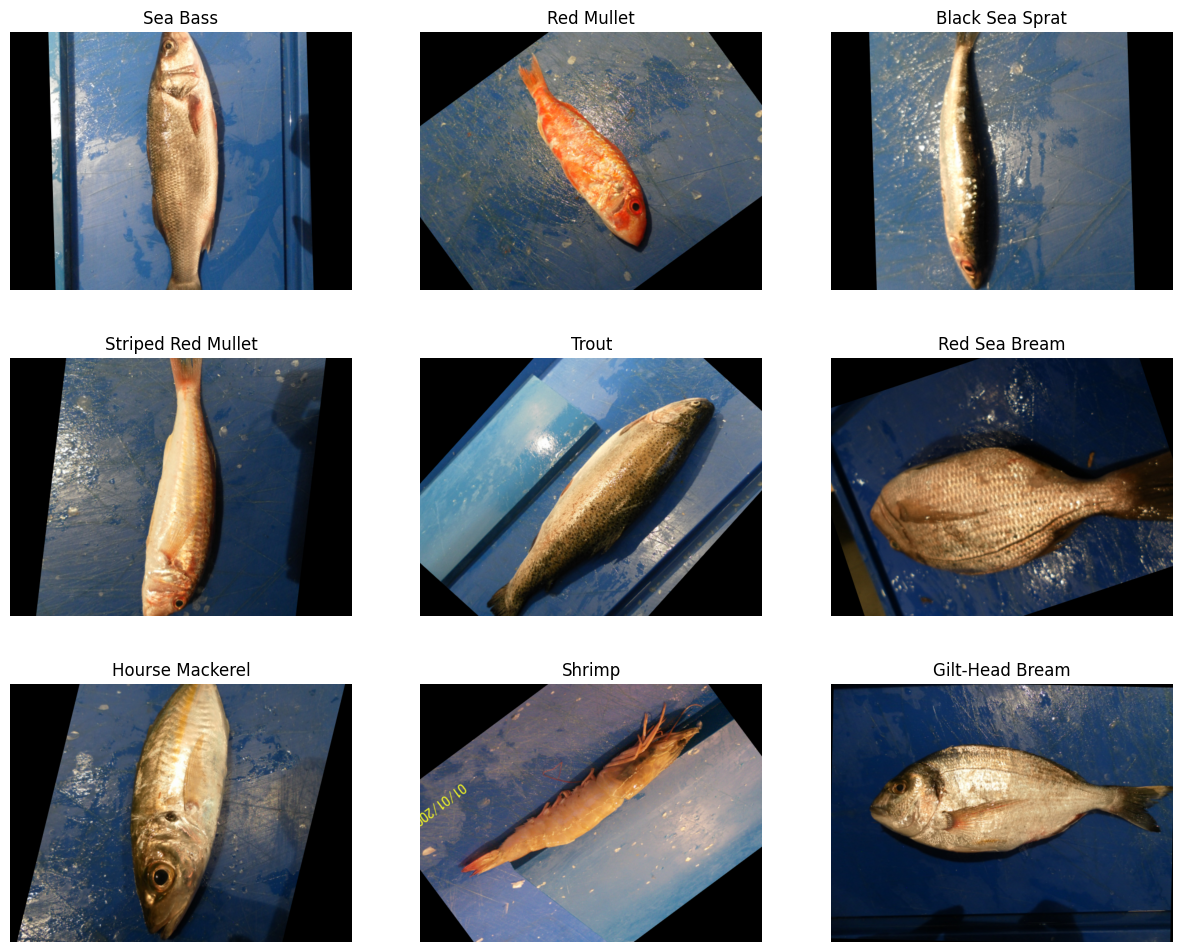

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
idx = 0
plt.figure(figsize=(15,12))
for unique_label in df['label'].unique():
    plt.subplot(3, 3, idx+1)
    plt.imshow(plt.imread(df[df['label']==unique_label].iloc[0,0]))
    plt.title(unique_label)
    plt.axis('off')
    idx+=1

In [91]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

In [92]:
print(train_df.shape)
print(test_df.shape)

(7200, 2)
(1800, 2)


In [93]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [94]:
# Set up ImageDataGenerator with rescaling for normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation settings for the training data
train_generator = ImageDataGenerator(
    rescale=1./255,                  # Rescale pixel values
    validation_split=0.2,            # Split for validation data
    # Data augmentation settings
    rotation_range=20,               # Randomly rotate images by 20 degrees
    width_shift_range=0.2,           # Randomly shift images horizontally by 20%
    height_shift_range=0.2,          # Randomly shift images vertically by 20%
    shear_range=0.2,                 # Randomly shear images
    zoom_range=0.2,                  # Randomly zoom images
    horizontal_flip=True,            # Randomly flip images horizontally
    fill_mode='nearest'              # Fill in missing pixels after transformations
)

# For validation and test data, we typically don't use augmentation
test_generator = ImageDataGenerator(rescale=1./255)

# Load training dataset with augmentation
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),          # Target size for images
    color_mode='rgb',                # Use RGB color mode
    class_mode='categorical',        # Multi-class classification
    batch_size=32,                   # Batch size
    shuffle=True,                    # Shuffle data
    seed=42,                         # Seed for reproducibility
    subset='training'                # Use the training subset
)

# Load validation dataset (without augmentation, just rescaling)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'             # Use the validation subset
)

# Load test dataset (no augmentation, just rescaling)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False                   # No shuffling for the test data
)


Found 5760 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


In [95]:
display(train_images.class_indices)
display(val_images.class_indices)
display(test_images.class_indices)

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

In [96]:
train_images

In [97]:
cnn = tf.keras.models.Sequential()

In [98]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [99]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [100]:
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [101]:
cnn.add(tf.keras.layers.Dropout(0.25))

In [102]:
cnn.add(tf.keras.layers.Flatten())

In [103]:
cnn.add(tf.keras.layers.Dense(units=512,activation='relu'))

In [104]:
cnn.add(tf.keras.layers.Dropout(0.4))

In [105]:
cnn.add(tf.keras.layers.Dense(units=9,activation='softmax'))

In [106]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [107]:
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      16,777,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,069,353 (65.11 MB)

 Trainable params: 17,069,353 (65.11 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
training_history = cnn.fit(x=train_images,validation_data=val_images,epochs=8)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


180/180 ━━━━━━━━━━━━━━━━━━━━ 116s 598ms/step - accuracy: 0.1571 - loss: 2.1057 - val_accuracy: 0.2986 - val_loss: 1.7679
Epoch 2/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 96s 511ms/step - accuracy: 0.3566 - loss: 1.6309 - val_accuracy: 0.4965 - val_loss: 1.3311
Epoch 3/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 486ms/step - accuracy: 0.5142 - loss: 1.2517 - val_accuracy: 0.6299 - val_loss: 1.0123
Epoch 4/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 489ms/step - accuracy: 0.6087 - loss: 1.0353 - val_accuracy: 0.5604 - val_loss: 1.1168
Epoch 5/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 142s 488ms/step - accuracy: 0.6486 - loss: 0.9309 - val_accuracy: 0.7007 - val_loss: 0.7673
Epoch 6/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 142s 488ms/step - accuracy: 0.6996 - loss: 0.7848 - val_accuracy: 0.7410 - val_loss: 0.6957
Epoch 7/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 488ms/step - accuracy: 0.7314 - loss: 0.7273 - val_accuracy: 0.7979 - val_loss: 0.5674
Epoch 8/8
180/180 ━━━━━━━━━━━━━━━━━━━━ 90s 487ms/step - accuracy: 0.7821 - loss: 0.5980 - val_acc

In [109]:
train_loss, train_acc = cnn.evaluate(train_images)
print('Training accuracy:', train_acc)

180/180 ━━━━━━━━━━━━━━━━━━━━ 70s 388ms/step - accuracy: 0.8584 - loss: 0.4087
Training accuracy: 0.8583333492279053


In [131]:
test_loss, test_acc = cnn.evaluate(test_images)
print('Testing accuracy:', test_acc)

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 274ms/step - accuracy: 0.8777 - loss: 0.3458
Testing accuracy: 0.8722222447395325


In [110]:
val_loss, val_acc = cnn.evaluate(val_images)
print('Validation accuracy:', val_acc)

45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 385ms/step - accuracy: 0.8602 - loss: 0.4184
Validation accuracy: 0.8527777791023254


In [111]:
cnn.save('fish_prediction_model.keras')

In [112]:
training_history.history

{'accuracy': [0.20277777314186096,
  0.38315972685813904,
  0.543749988079071,
  0.6293402910232544,
  0.6694444417953491,
  0.7203124761581421,
  0.7515624761581421,
  0.7857638597488403],
 'loss': [1.996280550956726,
  1.5587095022201538,
  1.205357313156128,
  0.97381192445755,
  0.8873088359832764,
  0.7507966756820679,
  0.6704543828964233,
  0.5757503509521484],
 'val_accuracy': [0.2986111044883728,
  0.4965277910232544,
  0.6298611164093018,
  0.5604166388511658,
  0.7006944417953491,
  0.7409722208976746,
  0.7979166507720947,
  0.855555534362793],
 'val_loss': [1.7679219245910645,
  1.331133484840393,
  1.0123087167739868,
  1.1168479919433594,
  0.7672727108001709,
  0.6956923604011536,
  0.5674005150794983,
  0.40677207708358765]}

In [113]:
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [114]:
print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


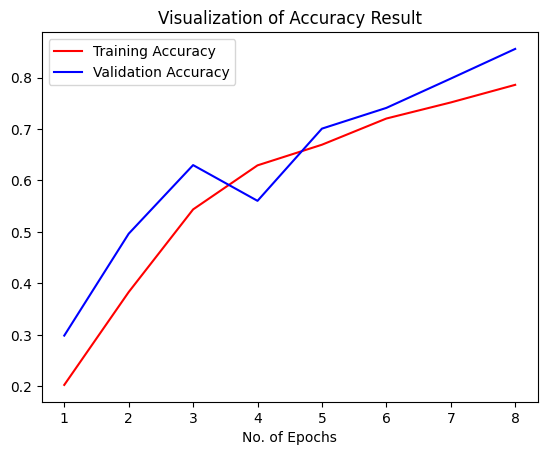

In [115]:
epochs = range(1, len(training_history.history['accuracy']) + 1)

plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()

In [116]:
cnn = tf.keras.models.load_model('fish_prediction_model.keras')

In [117]:
y_pred = cnn.predict(test_images)
predicted_categories = tf.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 407ms/step


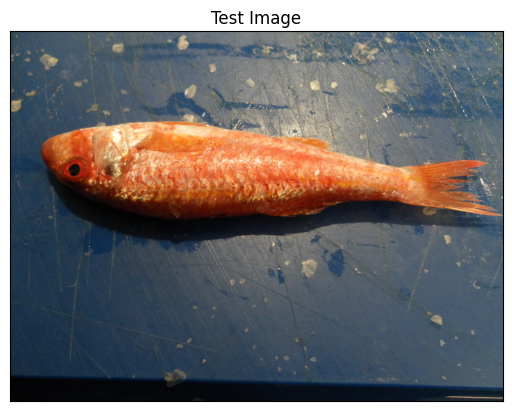

In [139]:
import cv2
image_path = '/content/NA_Fish_Dataset/Red Mullet/00021.png'
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [140]:
image = tf.keras.preprocessing.image.load_img(image_path,target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = cnn.predict(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [141]:
print(predictions)

[[0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [142]:
result_index = np.argmax(predictions) #Return index of max element
print(result_index)

3


In [143]:
class_indices = test_images.class_indices

class_names = list(class_indices.keys())

print("Class Names:", class_names)

Class Names: ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


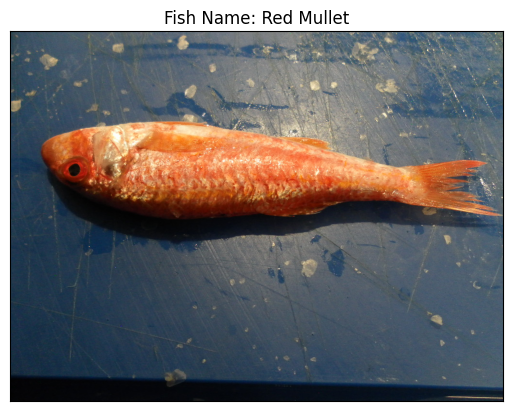

In [144]:
model_prediction = class_names[result_index]
plt.imshow(img)
plt.title(f"Fish Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step


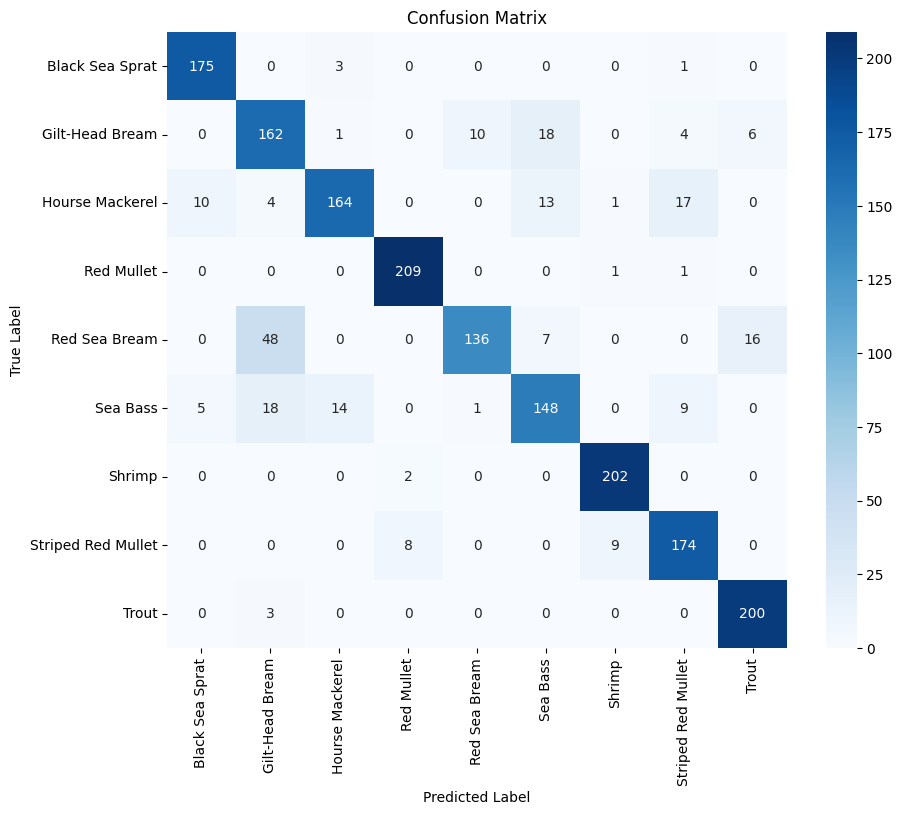

                    precision    recall  f1-score   support

   Black Sea Sprat       0.92      0.98      0.95       179
   Gilt-Head Bream       0.69      0.81      0.74       201
   Hourse Mackerel       0.90      0.78      0.84       209
        Red Mullet       0.95      0.99      0.97       211
     Red Sea Bream       0.93      0.66      0.77       207
          Sea Bass       0.80      0.76      0.78       195
            Shrimp       0.95      0.99      0.97       204
Striped Red Mullet       0.84      0.91      0.88       191
             Trout       0.90      0.99      0.94       203

          accuracy                           0.87      1800
         macro avg       0.88      0.87      0.87      1800
      weighted avg       0.88      0.87      0.87      1800



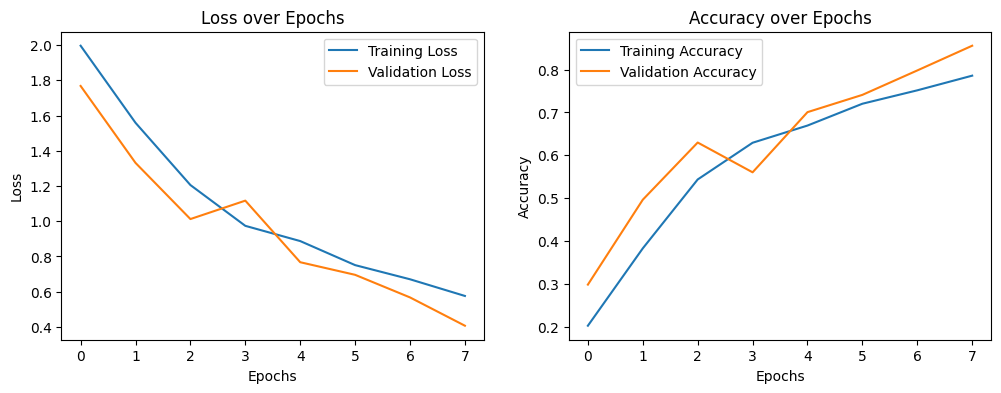

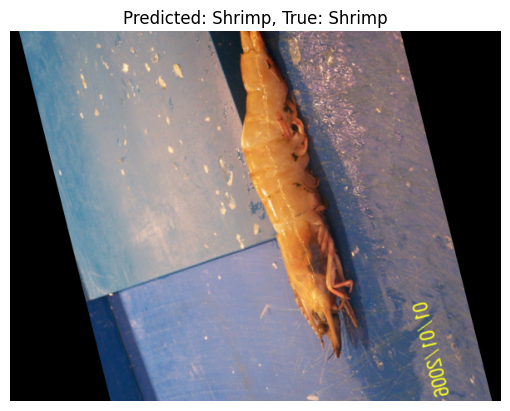

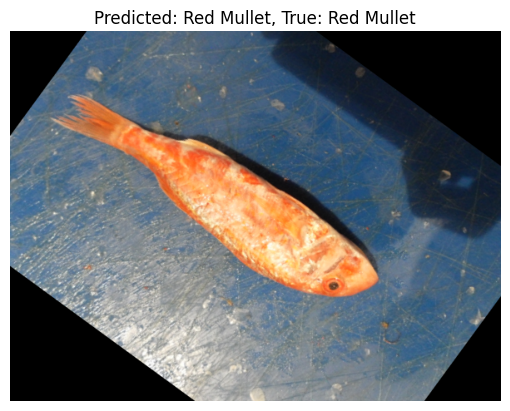

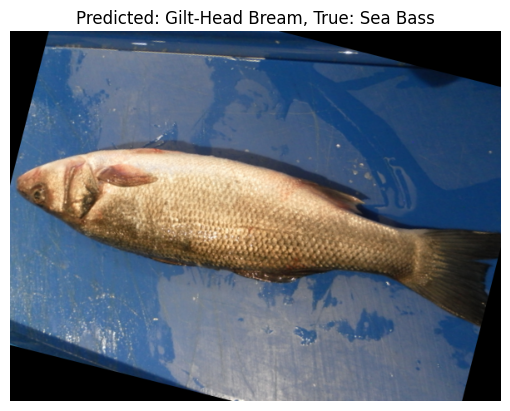

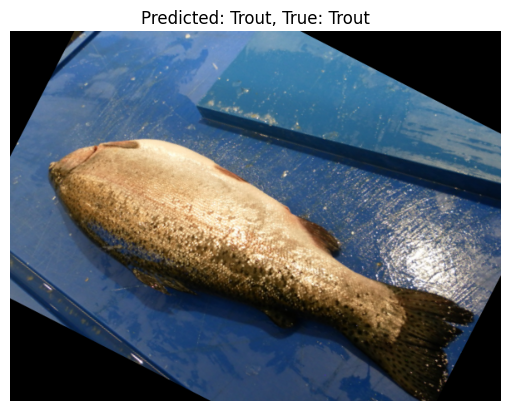

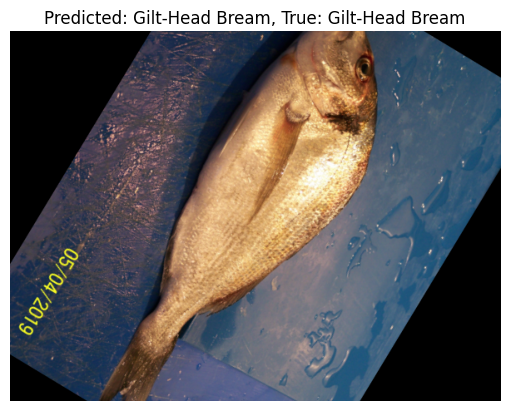

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import cv2


y_pred = cnn.predict(test_images)
predicted_categories = np.argmax(y_pred, axis=1)

y_true = test_images.classes

cm = confusion_matrix(y_true, predicted_categories)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_images.class_indices.keys()), yticklabels=list(test_images.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print(classification_report(y_true, predicted_categories, target_names=list(test_images.class_indices.keys())))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'], label='Training Loss')
plt.plot(training_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'], label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

with open('training_hist.json', 'w') as f:
    json.dump(training_history.history, f)

for i in range(5):
    img_path = test_images.filepaths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_categories[i]]}, True: {class_names[y_true[i]]}")
    plt.axis('off')
    plt.show()


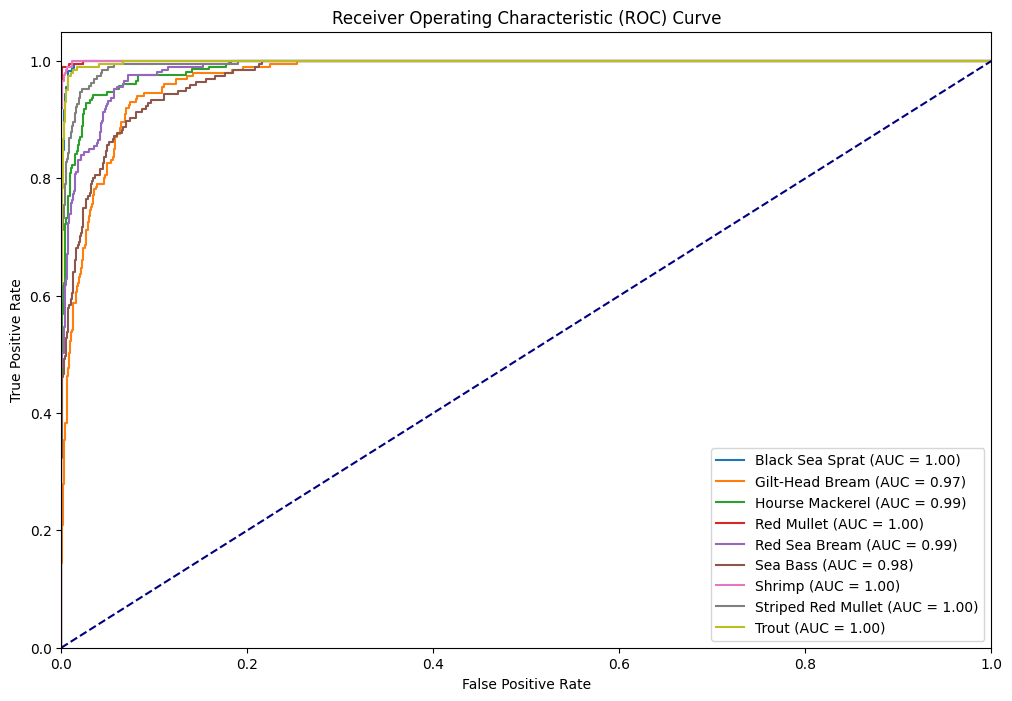

In [125]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))
y_pred_bin = label_binarize(predicted_categories, classes=np.arange(len(class_names)))

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


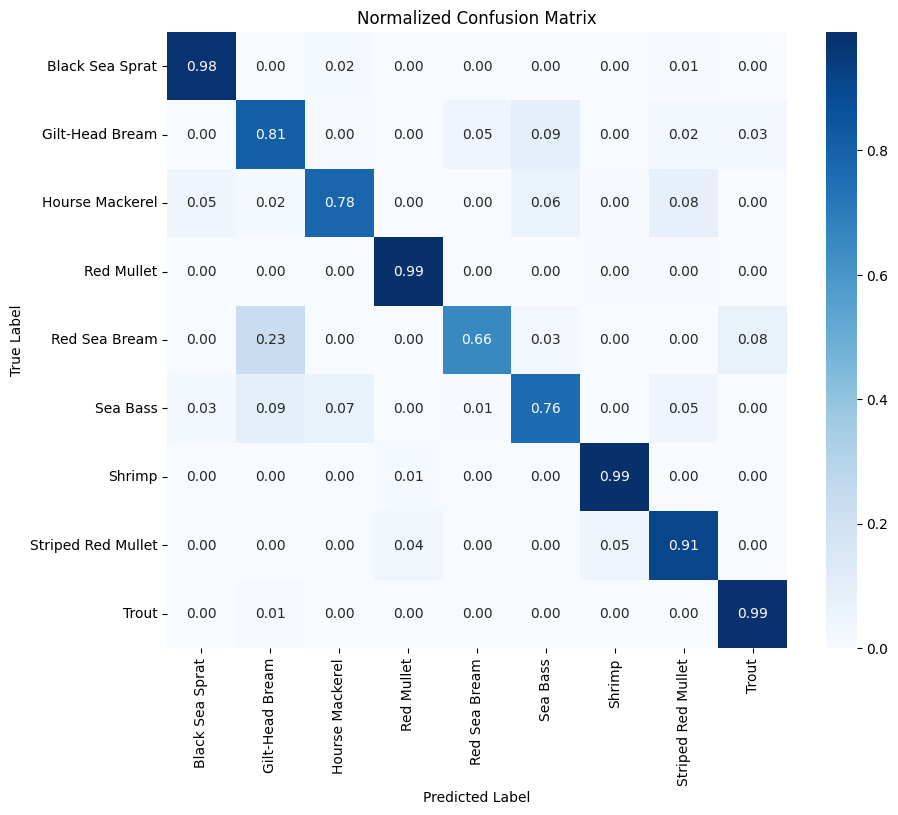

In [126]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


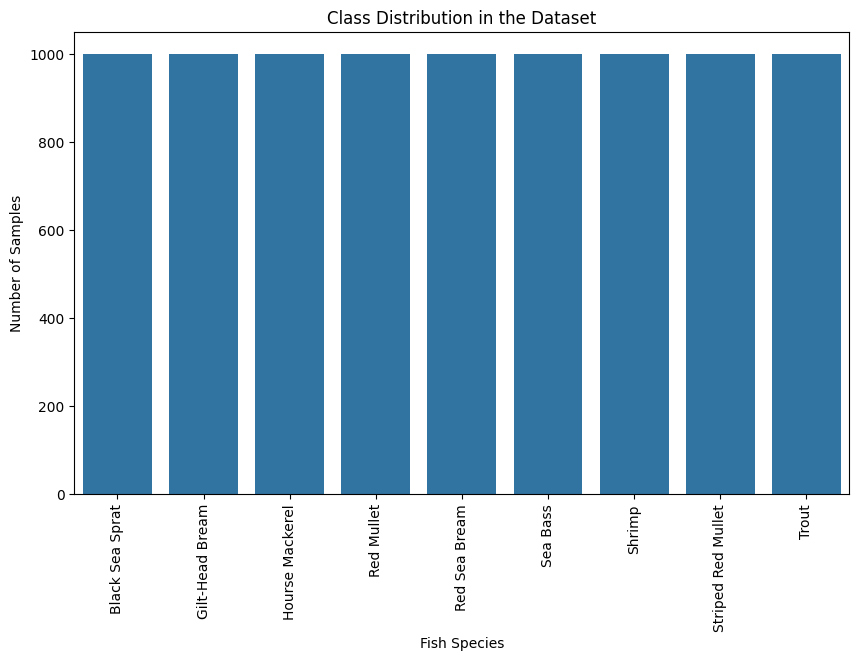

In [127]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, order=class_names)
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=90)
plt.xlabel('Fish Species')
plt.ylabel('Number of Samples')
plt.show()

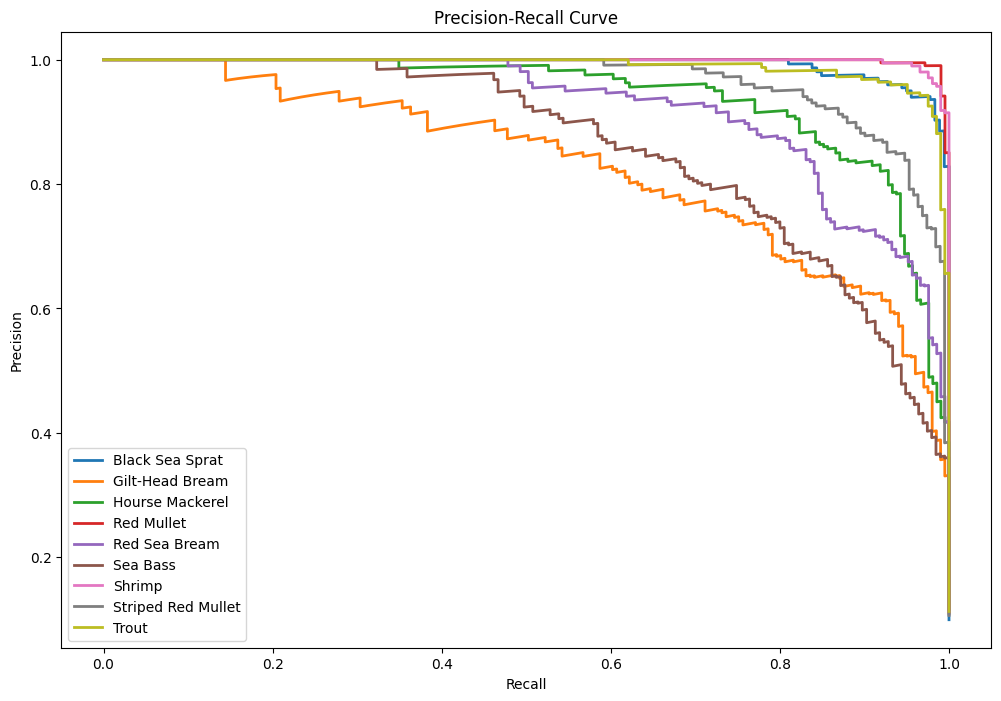

In [128]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(12, 8))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [149]:
import numpy as np
from sklearn.metrics import classification_report

# Get predictions from the model (predicted class probabilities)
predictions = cnn.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels from the test generator
true_labels = test_images.classes

# Get class names (target_names) from the test generator
target_names = list(test_images.class_indices.keys())

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=target_names)

print(report)


57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 288ms/step
                    precision    recall  f1-score   support

   Black Sea Sprat       0.92      0.98      0.95       179
   Gilt-Head Bream       0.69      0.81      0.74       201
   Hourse Mackerel       0.90      0.78      0.84       209
        Red Mullet       0.95      0.99      0.97       211
     Red Sea Bream       0.93      0.66      0.77       207
          Sea Bass       0.80      0.76      0.78       195
            Shrimp       0.95      0.99      0.97       204
Striped Red Mullet       0.84      0.91      0.88       191
             Trout       0.90      0.99      0.94       203

          accuracy                           0.87      1800
         macro avg       0.88      0.87      0.87      1800
      weighted avg       0.88      0.87      0.87      1800

